# Solution

## Import Libraries

## Goal

Explain the three most common sources of bias in customer satisfaction surveys—sampling bias, non-response bias, and seasonal bias—and show practical ways to detect/mitigate them using survey design and simple statistical corrections.

## Problem Statement

A company emails a survey link to a random sample of 10,000 customers who (1) made a purchase in the last 6 months and (2) live in New York City. The survey asks about customer service, product quality, and overall satisfaction. The company plans targeted improvements based on responses.

**Question:** What biases can invalidate the conclusions, and how would you address them?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## Problem Analysis

Even though the email list is “random,” the **sampling frame** is constrained (NYC + last-6-month purchasers). That means any estimate you compute from responses (e.g., average satisfaction) is at risk of being **systematically different** from the true company-wide customer experience.

We’ll focus on three common failure modes:
- **Sampling bias** (coverage/representativeness): who *can* be sampled is already biased.
- **Non-response bias** (missingness): who *chooses* to respond is not random.
- **Seasonal bias** (time effects): when you survey can shift satisfaction due to seasonal operations, promotions, and holidays.

In the Python sections below, examples are **illustrative simulations** meant to show mechanisms and diagnostics (e.g., achieved strata proportions, propensity score range, weight range, effective sample size).

The Hidden Tax of Bad Survey Design: Why Most Customer Satisfaction Studies Fail
Most companies treat customer satisfaction surveys as checkbox exercises. Email 10,000 customers, collect responses, present findings to leadership. But here's the uncomfortable truth: flawed survey design doesn't just produce bad data—it actively misleads decision-makers into making expensive, wrong choices.

This breakdown examines three statistical biases that plague customer satisfaction research and shows you how to detect and fix them using both design interventions and statistical corrections (with Python implementations).

## Bias #1: Sampling Bias (The Representativeness Problem)

What It Is
Sampling bias occurs when your survey population systematically differs from your true target population. Even with random selection within the NYC 6-month cohort, you're excluding:

1) Customers from other regions (different service centers, shipping times, cultural preferences)
2) Long-term customers who haven't purchased recently (retention insights)
3) Customers who browsed but didn't purchase (conversion friction points)

Why It Matters
If NYC customers rate customer service 4.2/5 but the Midwest rates it 3.1/5 due to understaffed regional centers, your "data-driven" improvements will miss the actual problem affecting 60% of your customer base.

The Fix: Stratified Sampling
Expand your sampling frame to include:
1) Geographic diversity: Sample proportionally from all regions
2) Purchase recency: Include customers with purchases in the last 12 months
3) Engagement levels: Include non-purchasers who engaged with your site

### Python Example: Stratified Sampling

In [5]:
# Assume we have a customer database
np.random.seed(42)
customers = pd.DataFrame({
    'customer_id': range(1, 100001),
    'region': np.random.choice(['NYC', 'Midwest', 'South', 'West'], 100000, p=[0.25, 0.35, 0.20, 0.20]),
    'last_purchase_months': np.random.exponential(8, 100000),
    'engagement_level': np.random.choice(['high', 'medium', 'low', 'none'], 100000, p=[0.20, 0.30, 0.30, 0.20])
})

# Original biased approach (NYC only, last 6 months)
biased_frame = customers[(customers['region'] == 'NYC') & (customers['last_purchase_months'] <= 6)]
biased_sample = biased_frame.sample(n=min(10000, len(biased_frame)), random_state=42)

print(f"Biased sample size: {len(biased_sample)}")
print(f"Region distribution:\n{biased_sample['region'].value_counts(normalize=True)}")

# Improved stratified sampling
def stratified_sample(df, strata_col, n_samples, random_state=42):
    """Sample (approximately) proportionally from each stratum, targeting exactly n_samples."""
    strata_props = df[strata_col].value_counts(normalize=True)
    exact = strata_props * n_samples
    base = np.floor(exact).astype(int)

    # Distribute rounding remainder to the strata with largest fractional parts
    remainder = int(n_samples - base.sum())
    if remainder > 0:
        frac = (exact - base).sort_values(ascending=False)
        base.loc[frac.index[:remainder]] += 1

    rng = np.random.RandomState(random_state)
    chosen_parts = []
    chosen_idx = set()

    # Use an int32-safe range for numpy RandomState
    seed_high = 2**31 - 1

    for stratum, n_stratum in base.items():
        stratum_df = df[df[strata_col] == stratum]
        if n_stratum <= 0 or len(stratum_df) == 0:
            continue
        n_take = min(int(n_stratum), len(stratum_df))
        part = stratum_df.sample(n=n_take, random_state=int(rng.randint(0, seed_high)))
        chosen_parts.append(part)
        chosen_idx.update(part.index.tolist())

    out = pd.concat(chosen_parts) if chosen_parts else df.head(0).copy()

    # Top up if any strata were too small to meet their allocation
    if len(out) < n_samples:
        remaining = df.drop(index=list(chosen_idx), errors='ignore')
        n_missing = n_samples - len(out)
        if len(remaining) > 0:
            topup = remaining.sample(n=min(n_missing, len(remaining)), random_state=int(rng.randint(0, seed_high)))
            out = pd.concat([out, topup])

    return out.sample(n=min(n_samples, len(out)), random_state=random_state).reset_index(drop=True)

# Stratify by region AND purchase recency
customers['recency_tier'] = pd.cut(
    customers['last_purchase_months'],
    bins=[0, 6, 12, 24, np.inf],
    labels=['0-6mo', '6-12mo', '12-24mo', '24mo+']
 )

customers['strata'] = customers['region'] + '_' + customers['recency_tier'].astype(str)
stratified_sample_df = stratified_sample(customers, 'strata', n_samples=10000)

print(f"\nStratified sample size: {len(stratified_sample_df)}")
print(f"Region distribution:\n{stratified_sample_df['region'].value_counts(normalize=True)}")
print(f"Recency distribution:\n{stratified_sample_df['recency_tier'].value_counts(normalize=True)}")

Biased sample size: 10000
Region distribution:
region
NYC    1.0
Name: proportion, dtype: float64

Stratified sample size: 10000
Region distribution:
region
Midwest    0.3495
NYC        0.2505
South      0.2010
West       0.1990
Name: proportion, dtype: float64
Recency distribution:
recency_tier
0-6mo      0.5261
6-12mo     0.2494
12-24mo    0.1742
24mo+      0.0503
Name: proportion, dtype: float64


This approach ensures your survey reflects the true composition of your customer base, not just a convenient subset.


## Bias #2: Non-Response Bias (The Silent Majority Problem)

What It Is
Even with perfect sampling, you face a second threat: not everyone responds. Typical survey response rates hover around 10-30%. The problem? Respondents aren't random—they're systematically different from non-respondents.

Who responds:

1) Extremely satisfied customers (want to praise)
2) Extremely dissatisfied customers (want to complain)

Who doesn't respond:
1) Moderately satisfied customers (the silent majority)
2) Busy customers
3) Survey-fatigued customers

Why It Matters
If your response rate is 15%, and responders skew toward extremes, your average satisfaction score is biased. You might see a 4.1/5 average when the true population average is 3.6/5—leading you to underinvest in improvements.

The Fix: Incentivization + Propensity Score Weighting
Design interventions:
1) Offer small incentives (gift cards, discounts, prize draws)
2) Keep surveys short (under 5 minutes)
3) Send reminders (but don't spam)
4) Communicate impact ("Your feedback shapes our 2026 roadmap")

## Python Example: Propensity Score Weighting   

### Why inverse-propensity weighting works (and when it doesn’t)
Inverse propensity weighting can only correct non-response bias if the probability of response is *explainable using observed variables* (a “missing at random” assumption).
- If response depends on an unobserved driver (e.g., true satisfaction) and you **don’t** have a proxy in the model, the estimated propensities will be nearly constant and weights won’t change much.
- In practice you use proxies like: prior NPS, complaint history, churn risk, support tickets, delivery delays, etc.

Response rate: 15.570%
True population mean satisfaction: 3.595
Observed (biased) mean satisfaction: 3.811

Weighted (corrected) mean satisfaction: 3.609
Bias reduction: 0.015 vs 0.217
Propensity score range (raw): 0.0519 to 0.3080
Weight range (clipped): 3.25 to 19.28
Effective sample size (ESS): 1377 out of 1557 responders


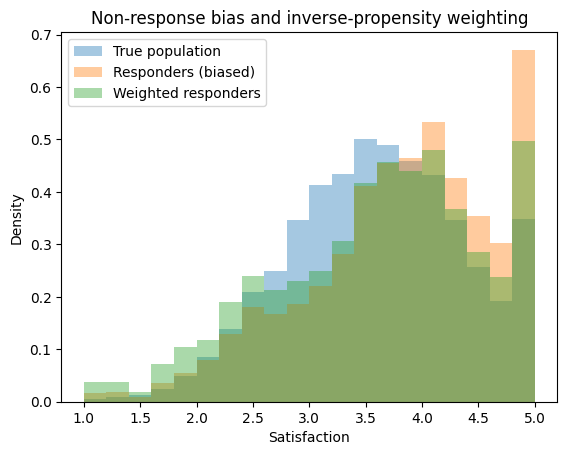

In [6]:
# Demonstration: include an observed proxy for satisfaction so weighting actually corrects the bias
from sklearn.linear_model import LogisticRegression

np.random.seed(123)
survey2 = pd.DataFrame({
    'customer_id': range(1, 10001),
    'satisfaction_true': np.random.normal(3.6, 0.8, 10000).clip(1, 5),
    'age': np.random.normal(40, 15, 10000).clip(18, 80),
    'purchase_frequency': np.random.poisson(3, 10000),
    'region': np.random.choice(['NYC', 'Midwest', 'South', 'West'], 10000)
})

# Observed proxy a model can actually see (e.g., last rating); correlated with true satisfaction
survey2['satisfaction_proxy'] = (survey2['satisfaction_true'] + np.random.normal(0, 0.5, 10000)).clip(1, 5)

# Make response depend on true satisfaction and region so the model has signal to learn
region_bonus = {'NYC': 0.05, 'Midwest': 0.00, 'South': -0.02, 'West': 0.02}
distance = np.abs(survey2['satisfaction_true'] - 3.0)
survey2['response_prob'] = (0.05 + 0.12 * distance + survey2['region'].map(region_bonus)).clip(0.02, 0.6)
survey2['responded'] = np.random.binomial(1, survey2['response_prob'])

responses2 = survey2[survey2['responded'] == 1].copy()

print(f"Response rate: {responses2.shape[0] / survey2.shape[0]:.3%}")
print(f"True population mean satisfaction: {survey2['satisfaction_true'].mean():.3f}")
print(f"Observed (biased) mean satisfaction: {responses2['satisfaction_true'].mean():.3f}")

# Propensity model includes observed proxy and region
X2 = pd.get_dummies(
    survey2[['age', 'purchase_frequency', 'region', 'satisfaction_proxy']],
    columns=['region'], drop_first=True
)
y2 = survey2['responded']

propensity_model2 = LogisticRegression(random_state=123, max_iter=1000)
propensity_model2.fit(X2, y2)

responsesX2 = pd.get_dummies(
    responses2[['age', 'purchase_frequency', 'region', 'satisfaction_proxy']],
    columns=['region'], drop_first=True
)
responsesX2 = responsesX2.reindex(columns=X2.columns, fill_value=0)

responses2['propensity_score'] = propensity_model2.predict_proba(responsesX2)[:, 1]

# Weighting can explode if propensity is near 0. Clip to keep weights finite (common practical step).
eps = 0.01
responses2['propensity_score_clipped'] = responses2['propensity_score'].clip(eps, 1 - eps)
responses2['weight'] = 1 / responses2['propensity_score_clipped']

weighted_mean2 = np.average(responses2['satisfaction_true'], weights=responses2['weight'])

# Effective sample size (how much information remains after weighting)
ess = (responses2['weight'].sum() ** 2) / (responses2['weight'] ** 2).sum()

print(f"\nWeighted (corrected) mean satisfaction: {weighted_mean2:.3f}")
print(
    f"Bias reduction: {abs(weighted_mean2 - survey2['satisfaction_true'].mean()):.3f} "
    f"vs {abs(responses2['satisfaction_true'].mean() - survey2['satisfaction_true'].mean()):.3f}"
)
print(f"Propensity score range (raw): {responses2['propensity_score'].min():.4f} to {responses2['propensity_score'].max():.4f}")
print(f"Weight range (clipped): {responses2['weight'].min():.2f} to {responses2['weight'].max():.2f}")
print(f"Effective sample size (ESS): {ess:.0f} out of {len(responses2)} responders")

# Quick visualization: true vs observed vs weighted distributions
bins = np.linspace(1, 5, 21)
plt.hist(survey2['satisfaction_true'], bins=bins, alpha=0.4, label='True population', density=True)
plt.hist(responses2['satisfaction_true'], bins=bins, alpha=0.4, label='Responders (biased)', density=True)
plt.hist(responses2['satisfaction_true'], bins=bins, weights=responses2['weight'], alpha=0.4, label='Weighted responders', density=True)
plt.xlabel('Satisfaction')
plt.ylabel('Density')
plt.title('Non-response bias and inverse-propensity weighting')
plt.legend()
plt.show()

## Bias #3: Seasonal Bias (The Timing Trap)

What It Is
Seasonal bias occurs when survey timing captures period-specific patterns that don't generalize year-round. Customer satisfaction fluctuates with:

1) Holiday shopping stress: Longer shipping times, out-of-stock items, overwhelmed support teams
2) Product seasonality: Winter coat buyers in December have different needs than summer sandal buyers in June
3) Promotional periods: Discount shoppers may rate price satisfaction higher than full-price shoppers

Why It Matters
If you survey in December and allocate millions to "fix" shipping delays, you might over-correct for a seasonal spike while missing chronic issues in other quarters.

The Fix: Multi-Period Surveying
1) Conduct surveys quarterly or continuously throughout the year. Compare:
2) Cross-sectional approach: Single survey in Q4
3) Longitudinal approach: Four surveys (one per quarter) or rolling monthly surveys

In [9]:
# Simulate quarterly satisfaction data
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
np.random.seed(42)

quarterly_data = pd.DataFrame({
    'quarter': np.repeat(quarters, 2500),
    'satisfaction': np.concatenate([
        np.random.normal(3.7, 0.7, 2500),  # Q1: Normal
        np.random.normal(3.8, 0.7, 2500),  # Q2: Slight improvement
        np.random.normal(3.6, 0.8, 2500),  # Q3: Summer slowdown
        np.random.normal(3.3, 0.9, 2500),  # Q4: Holiday stress
    ]).clip(1, 5)
})

# Calculate quarterly means
quarterly_means = quarterly_data.groupby('quarter')['satisfaction'].agg(['mean', 'std', 'count'])
print("Quarterly satisfaction trends:")
print(quarterly_means)

# Statistical test: ANOVA to check if differences are significant
from scipy.stats import f_oneway

q1 = quarterly_data[quarterly_data['quarter'] == 'Q1']['satisfaction']
q2 = quarterly_data[quarterly_data['quarter'] == 'Q2']['satisfaction']
q3 = quarterly_data[quarterly_data['quarter'] == 'Q3']['satisfaction']
q4 = quarterly_data[quarterly_data['quarter'] == 'Q4']['satisfaction']

f_stat, p_value = f_oneway(q1, q2, q3, q4)
print(f"\nANOVA test for seasonal differences:")
print(f"F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✓ Significant seasonal variation detected — single-period surveys are insufficient")
else:
    print("✗ No significant seasonal variation — single-period survey may be acceptable")


Quarterly satisfaction trends:
             mean       std  count
quarter                           
Q1       3.714772  0.667929   2500
Q2       3.772736  0.681686   2500
Q3       3.561704  0.785097   2500
Q4       3.301034  0.868257   2500

ANOVA test for seasonal differences:
F-statistic: 194.70, p-value: 0.0000
✓ Significant seasonal variation detected — single-period surveys are insufficient


Output interpretation: If p<0.05 you have significant seasonal variation. A Q4-only survey would mislead you into thinking satisfaction is universally low, when it's actually a holiday-specific dip.

## Conclusion

If you don’t actively design against bias, a “data-driven” survey can easily become a decision-making trap: you learn a lot about *NYC + recent purchasers + people motivated to respond at that time of year*—not necessarily about your customer base.

**Practical checklist for your next survey**
- **Sampling/coverage:** ensure the sampling frame matches your true target population (regions, recency, engagement, device/channel). Prefer stratified sampling when key subgroups differ.
- **Non-response:** track response rates by subgroup; reduce friction (short survey), add incentives/reminders, and consider **inverse-propensity weighting** when you have good predictors of response.
- **Seasonality:** run surveys across multiple periods (quarterly or rolling). Compare results and test whether quarter-to-quarter differences are material.
- **Report diagnostics:** sample sizes per stratum, response rate, weight range, and **effective sample size (ESS)** if weighting is used.

The code above demonstrates the mechanics so you can adapt it to your customer database and analytics stack.

A well-designed survey costs marginally more than a poorly designed one, but the ROI difference is exponential. Investing $10K in incentives and $5K in statistical corrections beats wasting $500K on misguided product improvements based on biased data.

Action items for your next survey:

1) Map your sampling frame against your true target population—identify gaps
2) Calculate expected response rates and build propensity score models if rates dip below 40%
3) Run pilot surveys across seasons before committing to a single-period design
4) Automate weighting and bias detection using the Python code above